# Linear Classifation Example
## Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math


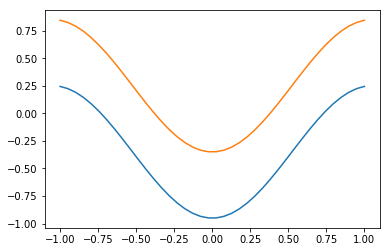

In [2]:
# define and plot 2 original curves
N = 40
x0 = np.linspace(-1,1,N)
y1 = -0.6*np.sin(math.pi/2+3*x0)-0.35
y2 = -0.6*np.sin(math.pi/2+3*x0)+0.25

plt.plot(x0, y1, x0, y2)
plt.show()

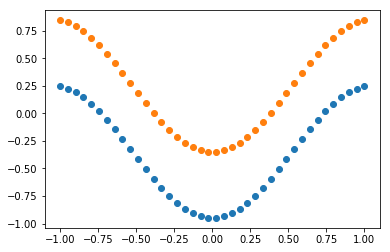

In [3]:
pos = np.array([x0,y1]).transpose()
neg = np.array([x0,y2]).transpose()
plt.plot(pos[:,0],pos[:,1],"o")
plt.plot(neg[:,0],neg[:,1],"o")
label = np.ones(N).transpose()
train = np.block([[x0,x0],[y1,y2],[label,-label]]).transpose()

In [4]:
x = train[:,0].reshape(2*N,1)
y = train[:,1].reshape(2*N,1)
t = train[:,2].reshape(2*N,1)


## First Trial: failed
Devide 2 curves with a straight line, using logistic regression to draw a straight line to the training dataset for classification

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


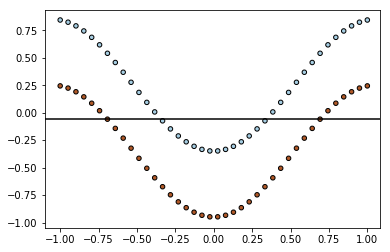

In [5]:
from sklearn.linear_model import LogisticRegression

X = np.block([x,y])

logreg = LogisticRegression().fit(X,t)

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
t_min, t_max = X[:, 1].min() - .1, X[:, 1].max() + .1
h = .02  # step size in the mesh
xx, tt = np.meshgrid(np.arange(x_min, x_max, h), np.arange(t_min, t_max, h))
Z = logreg.predict(np.c_[xx.ravel(), tt.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=t[:,0], edgecolors='black', cmap=plt.cm.Paired, s=20)
plt.contour(xx, tt, Z, levels = [-1.0, 0.0, 1.0], colors = 'k', linestyles = "solid")
plt.show()

## Second Trial: 
Trasfer the space(x, y) to (xhat, yhat) and then classification in the new space
### Illustration of the optimization
Use grid search to find the linear classifier that perfectly separate the two twisted lines

In [20]:
def opt(x,y):
    for w11 in range(-3,4,1):
        for w12 in range(-3,4,1):
            for w21 in range(-3,4,1):
                for w22 in range(-3,4,1):
                    for b1 in range(-1,2,1):
                        for b2 in range(-1,2,1):
                            xhat = np.tanh(w11*x + w21*y + b1)
                            yhat = np.tanh(w12*x + w22*y + b2)
                            eta = np.block([xhat, yhat, np.ones([2*N,1])])
                            for a in range(-3,3,1):
                                for b in range(-3,3,1):
                                    for c in range(-3,3,1):
                                        w = np.array([[a,b,c]]).transpose()
                                        S = -sum(np.matmul(eta*t,w)*(np.matmul(eta*t,w)<=0)).transpose()[0]
                                        if S == 0:
                                            weight = [a,b,c,w11,w12,w21,w22,b1,b2]
                                            return weight
w = opt(x,y)
w

[-2, 2, 0, -3, -3, -3, -3, -1, -1]

### Visualize the linear classification in the twisted new space

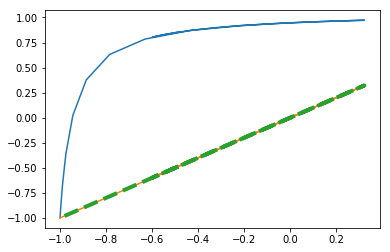

In [21]:
x0hat = np.tanh(w[3]*x0 + w[5]*y2 + w[7])
y1hat = np.tanh(w[4]*x0 + w[6]*y1 + w[8])
y2hat = np.tanh(w[4]*x0 + w[6]*y2 + w[8])
plt.plot(x0hat, y1hat, x0hat, y2hat)
line = -w[0]/w[1]*x0hat - w[2]/w[1]
plt.plot(x0hat, line, linestyle='dashed', linewidth=4)
plt.show() 

## Final Trial: 
Consider the "distance" concept in optimization to find the best classifier. Different Kernel methods with SVM classifier as implemented to separate the data

### 1. Polynormial Kernel (failed)

In [22]:
from sklearn.linear_model import SGDClassifier

X = np.block([x,y])

# fit the model
from sklearn.svm import SVC  
svclassifier = SVC(kernel='poly', degree=8)  
svclassifier.fit(X, t)  

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=8, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
# Evaluate the classification, we can see Polynormial kernel cannot perfectly seperate the 2 lines
t_pred = svclassifier.predict(X) 

from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(t, t_pred))  
print(classification_report(t, t_pred))  

[[ 4 36]
 [ 0 40]]
             precision    recall  f1-score   support

       -1.0       1.00      0.10      0.18        40
        1.0       0.53      1.00      0.69        40

avg / total       0.76      0.55      0.44        80



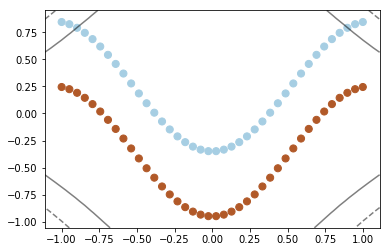

In [24]:
# Visualize Polynormial kernel classifier

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    
plt.scatter(X[:, 0], X[:, 1], c=t[:,0], s=50, cmap=plt.cm.Paired)
plot_svc_decision_function(svclassifier)
plt.scatter(svclassifier.support_vectors_[:, 0], svclassifier.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### 2. Sigmoid Kernel (failed)

In [25]:
# fit the model
svclassifier = SVC(kernel='sigmoid')  
svclassifier.fit(X, t)  

# Evaluate the classification, we can see Sigmoid kernel cannot perfectly seperate the 2 lines
t_pred = svclassifier.predict(X) 

from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(t, t_pred))  
print(classification_report(t, t_pred)) 

[[26 14]
 [14 26]]
             precision    recall  f1-score   support

       -1.0       0.65      0.65      0.65        40
        1.0       0.65      0.65      0.65        40

avg / total       0.65      0.65      0.65        80



/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


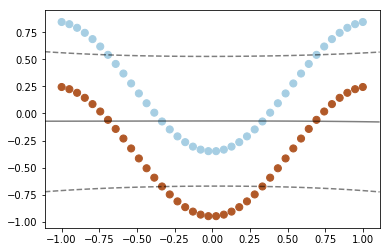

In [26]:
# Visualize Sigmoid kernel classifier
    
plt.scatter(X[:, 0], X[:, 1], c=t[:,0], s=50, cmap=plt.cm.Paired)
plot_svc_decision_function(svclassifier)
plt.scatter(svclassifier.support_vectors_[:, 0], svclassifier.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### 3. Gaussian Kernel (succeed)

In [27]:
# fit the model
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(X, t)  

# Evaluate the classification, we can see Gaussian kernel perfectly seperate the 2 lines
t_pred = svclassifier.predict(X) 

from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(t, t_pred))  
print(classification_report(t, t_pred)) 

[[40  0]
 [ 0 40]]
             precision    recall  f1-score   support

       -1.0       1.00      1.00      1.00        40
        1.0       1.00      1.00      1.00        40

avg / total       1.00      1.00      1.00        80



/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


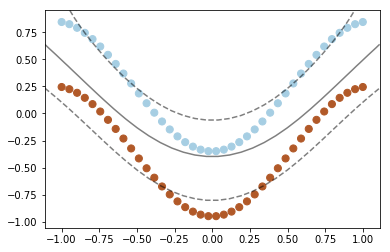

In [28]:
# Visualize Gaussian kernel classifier
    
plt.scatter(X[:, 0], X[:, 1], c=t[:,0], s=50, cmap=plt.cm.Paired)
plot_svc_decision_function(svclassifier)
plt.scatter(svclassifier.support_vectors_[:, 0], svclassifier.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### Referece of SVM: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
        